In [1]:
import ortools
from ortools.constraint_solver import routing_enums_pb2
import ortools.constraint_solver.pywrapcp as pywrapcp
from PIL import Image
from IPython.display import display
import pandas as pd
from itertools import zip_longest
from geopy.distance import geodesic

import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score

import warnings
warnings.filterwarnings("ignore")

import numpy as np

import requests

import folium

import seaborn as sns

import itertools
import math

In [3]:
caminho = r"ara_adm (1) - Copia.xlsx".replace("\\","/")
teste = pd.read_excel(caminho)
teste = teste.drop_duplicates()
teste = teste.reset_index()
teste['lat'] = teste['lat'].astype(str)
teste['long'] = teste['long'].astype(str)
teste['lat'] = teste['lat'].str.replace(",",".")
teste['long'] = teste['long'].str.replace(",",".")
teste['lat'] = teste['lat'].astype(float)
teste['long'] = teste['long'].astype(float)
teste['qtd'] = teste['qtd'].astype(int)

teste.head()

,index,nome_local,qtd,lat,long,rota_original,start
0,0,Fábrica,0,-19.837913,-40.082170,-1,NaN
1,1,Ponto ao lado do antigo DPM,5,-19.903273,-40.232890,0,NaN
2,2,Primo Bitti - Parada do Caranguejo - Irajá,2,-19.904354,-40.223015,0,NaN
3,3,Primo Bitti-início de Caieiras Velha- prox. Es...,2,-19.920553,-40.174908,0,NaN
4,4,Primo Bitti - Saída de Caieiras Velha sent. Co...,2,-19.927172,-40.164630,0,NaN


In [4]:
def verificar_coluna(dataframe, nome_coluna):
    if nome_coluna in dataframe.columns:
        return True
    else:
        return False

# Parâmetros globais

### EM caso da(s) coluna(s) 'start'/'rota_original' existir no Data Frame

In [5]:
if verificar_coluna(teste, 'qtd') == False:
    print("A quantidade de passageiros em cada ponto deve ser especificada")

In [6]:
if verificar_coluna(teste, 'start') == True:
    teste['start'] = teste['start'].astype(str)
    teste['start'] = teste['start'].str.strip()
    teste['start'] = teste['start'].str.lower()
    starts = teste[teste['start']=='x']['index'].unique()
    n_routs_desirable = len(starts)
    initialize_starting_points = False
else:
    starts = None
    n_routs_desirable = None
    initialize_starting_points = True
    
if verificar_coluna(teste, 'rota_original') == True:
    teste['rota_original'] = teste['rota_original'].astype(int)
    rota_original = teste['rota_original'].unique()
else:
    rota_original = None

### Dados da API Directions

In [7]:
url = "https://route-and-directions.p.rapidapi.com/v1/routing"


headers = {
    "X-RapidAPI-Key": "38b8f9c50fmsh016cdd649c514d1p1caf6cjsne1d6770fec79",
    "X-RapidAPI-Host": "route-and-directions.p.rapidapi.com"
}

### Parâmetros de usuários

In [8]:
if n_routs_desirable == None:
    n_routs_desirable = int(input("Numero de rotas solicitadas"))

In [9]:
# Cpacidade dos veiculos
vehicle_capacity = 46
# Diretorio onde os arquivos serão salvos
directory_saves_files = r"C:\Users\MarkosPereira.exc\Downloads\Estudo de roteirização das rotas aracruz\demonstracao".replace("\\","/")

### Parâmetros de sistema

In [10]:
demands = list(teste['qtd'])
total_demands = teste['qtd'].sum()
depot = teste[teste['qtd']==0]['index'].unique()
lat_depot = teste[teste['qtd']==0]['lat'].unique()
long_depot = teste[teste['qtd']==0]['long'].unique()

## Preprocessamento de parâmetros globais

### Capacidade dos veículos

In [11]:
try:
    vehicle_capacity = int(vehicle_capacity)
    vehicle_capacities = [vehicle_capacity for _ in range(n_routs_desirable)]
    print(vehicle_capacities)
except:
    vehicle_capacity = list(vehicle_capacity)
    if len(vehicle_capacity) < n_routs_desirable:
        print("Frota muito pequena para a quantidade de rotas desejadas")
    elif len(vehicle_capacity) > n_routs_desirable:
        pass
    elif len(vehicle_capacity) == n_routs_desirable:
        print(vehicle_capacity)

[46, 46, 46, 46]


### Pontos de destino

In [12]:
if len(depot) == 1:
    depot = depot[0]
    ends = [depot for _ in range(n_routs_desirable)]
    print(ends)
elif len(depot) >= 1:
    if len(depot) < n_routs_desirable:
        print("Quantidade de destinos muito pequena para o numero de rotas desejadas")
    elif len(depot) > n_routs_desirable:
        pass
    elif len(depot) == n_routs_desirable:
        print(depot)

[0, 0, 0, 0]


### (Pré) Inicialização das rotas

In [13]:
print(initialize_starting_points)

False


# Criação distance Matrix

In [14]:
x = list(zip_longest(teste['lat'][:], teste['long'][:], fillvalue=None))

In [15]:
# Crie uma matriz de distância vazia
distance_matrix = []

# Calcule as distâncias entre todos os pares de coordenadas
for coord1 in x:
    distances = []
    for coord2 in x:
        distancia = geodesic(coord1, coord2).kilometers
        distances.append(distancia)
    distance_matrix.append(distances)

# Criação dos cluster de dados para agrupar os pontos de embarque

In [16]:
def cluster_data(data_frame, n_clusters):
    # Selecionar as colunas 'lat' e 'long'
    features = data_frame[['lat', 'long']]

    # Padronizar as features para média zero e desvio padrão 1
    scaler = StandardScaler()
    scaled_features = scaler.fit_transform(features)

    # Executar o algoritmo K-Means com o número de grupos especificado
    kmeans = KMeans(n_clusters=n_clusters, random_state=0)
    data_frame['cluster'] = kmeans.fit_predict(scaled_features)
    data_frame = data_frame.assign(row=1)

    return data_frame

# Visualização dos cluster de dados

In [17]:
def plot_clusters_on_map(data_frame, lat_col, long_col, cluster_col):
    # Extrair as coordenadas de latitude e longitude e os rótulos de grupo
    lats = data_frame[lat_col]
    longs = data_frame[long_col]
    clusters = data_frame[cluster_col]

    # Configurar o estilo do gráfico de dispersão
    sns.set(style='whitegrid')
    plt.figure(figsize=(10, 8))

    # Plotar os pontos coloridos por grupo
    sns.scatterplot(x=longs, y=lats, hue=clusters, palette='Set1', s=100, legend='full')

    # Configurar rótulos e título
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.title('Grupos de Dados no Mapa')

    # Mostrar a legenda
    plt.legend(title='Grupos', loc='upper right')

    # Calcular e plotar os centroides dos clusters
    centroids = data_frame.groupby(cluster_col)[[lat_col, long_col]].mean().reset_index()
    sns.scatterplot(x=centroids[long_col], y=centroids[lat_col], hue=centroids[cluster_col],
                    palette='Set1', s=200, marker='X', legend=False, ax=plt.gca())

    # Exibir o mapa
    plt.show()

    return centroids

# Carregar seu DataFrame pandas com as colunas 'lat', 'long', e 'cluster'
# df = pd.read_csv('seuarquivo.csv')

In [18]:
def haversine_distance(lat1, lon1, lat2, lon2):
    # Raio da Terra em quilômetros
    radius = 6371

    # Converte graus para radianos
    lat1 = np.radians(lat1)
    lon1 = np.radians(lon1)
    lat2 = np.radians(lat2)
    lon2 = np.radians(lon2)

    # Diferenças de latitude e longitude
    dlat = lat2 - lat1
    dlon = lon2 - lon1

    # Fórmula de Haversine
    a = np.sin(dlat/2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2)**2
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))
    distance = radius * c

    return distance

In [19]:
def calcular_proporcionais(valores, valor_base):
    # Verifica se a lista de valores não está vazia
    if not valores:
        return []

    # Calcula a soma dos valores na lista
    soma_valores = sum(valores)

    # Calcula os fatores de escala para manter a proporção
    fatores_escala = [valor_base / soma_valores * valor for valor in valores]

    # Arredonda os fatores de escala para números inteiros
    fatores_inteiros = [round(fator) for fator in fatores_escala]

    # Ajusta para garantir que a soma seja igual ao valor base
    diferenca = valor_base - sum(fatores_inteiros)
    fatores_inteiros[-1] += diferenca

    return fatores_inteiros

In [20]:
# Especificar o número desejado de grupos (n)
if initialize_starting_points == True: 
    n = n_routs_desirable
    n_clusters = int(n**0.5)
    # Chamar a função para agrupar os dados em n grupos
    clustered_df = cluster_data(teste[1:], n_clusters)
    # Chamar a função para plotar os grupos no mapa
    x = plot_clusters_on_map(clustered_df, 'lat', 'long', 'cluster')
    y = clustered_df[['cluster', 'qtd', 'row']].groupby('cluster').sum(['qtd', 'row']).sort_values('qtd', ascending=False)
    y = y.reset_index()
    z = pd.merge(x, y, on='cluster')
    z= z.assign(lat1= -19.837913) 
    z= z.assign(long1= -40.082170)
    z['distance'] = haversine_distance(z['lat'], z['long'], z['lat1'], z['long1'])
    z = z.sort_values('qtd', ascending=False)
    base = n_routs_desirable
    resultado = calcular_proporcionais(list(z['qtd']), base)
    z['n_routs'] = resultado

# Definição dos pontos de START das rotas

In [21]:
def calculate_best_starting_points_with_destination(latitudes, longitudes, demands, destination_latitude, destination_longitude, num_vehicles):
    # Índices possíveis para pontos de início
    possible_starts = list(range(len(latitudes)))

    # Combinar os índices dos pontos de início com a demanda total
    start_combinations = itertools.combinations(possible_starts, num_vehicles)

    best_starts_indices = min(start_combinations, key=lambda indices: sum(demands[i] for i in indices))

    # Obter as coordenadas correspondentes aos melhores pontos de início
    best_starting_points = [(latitudes[i], longitudes[i]) for i in best_starts_indices]

    # Adicionar o ponto de destino
    best_starting_points.append((destination_latitude, destination_longitude))

    return best_starting_points

In [22]:
list_to_stars_points = list()

if initialize_starting_points == True:
    for cluster in z['cluster'].unique():
        new_df = clustered_df[clustered_df['cluster']==cluster]
        n_points = z[z['cluster']==cluster]['n_routs'].unique()[0]
    #     print(n_points)
        best_starting_points = calculate_best_starting_points_with_destination(list(new_df['lat']), list(new_df['long']),list(new_df['qtd']), lat_depot[0],long_depot[0], n_points)
        list_to_stars_points.append(best_starting_points)
    #     display(new_df)
    #     print(best_starting_points)
    
else:
    start_latitudes = list()
    start_longitudes = list()
    for index in teste[teste['index'].isin(starts)]['index']:
        start_latitudes.append(teste.iloc[index]['lat'])   
        start_longitudes.append(teste.iloc[index]['long'])   


print(list_to_stars_points)
print(start_latitudes)
print(start_longitudes)

[]
[-20.374887, -20.34282, -20.28345, -20.350016]
[-40.307243, -40.393913, -40.30079, -40.34803]


In [23]:
# Visualização dos parametros ja inicializados 
print(starts)
print(ends)
print(n_routs_desirable)
print(demands)
print(total_demands)
print(depot)

[ 82  95  99 108]
[0, 0, 0, 0]
4
[0, 5, 2, 2, 2, 3, 1, 3, 3, 3, 1, 1, 5, 4, 5, 4, 4, 1, 1, 1, 1, 6, 1, 2, 14, 19, 10, 12, 14, 5, 3, 5, 5, 8, 18, 17, 12, 11, 10, 12, 8, 14, 2, 5, 8, 3, 6, 1, 6, 1, 1, 2, 3, 1, 8, 4, 2, 4, 12, 13, 7, 18, 12, 6, 2, 9, 8, 4, 12, 6, 4, 13, 24, 2, 2, 2, 10, 5, 4, 14, 9, 2, 1, 1, 4, 1, 1, 2, 2, 1, 4, 1, 1, 2, 1, 1, 2, 1, 1, 2, 2, 2, 1, 1, 2, 1, 5, 1, 1, 1, 1, 2, 4, 1, 6, 1, 2, 2, 1, 2, 2, 3, 1, 1, 1, 2, 3, 2, 5, 4, 1, 1, 3, 5, 1, 2, 2, 1, 5, 3, 2, 1, 3]
637
0


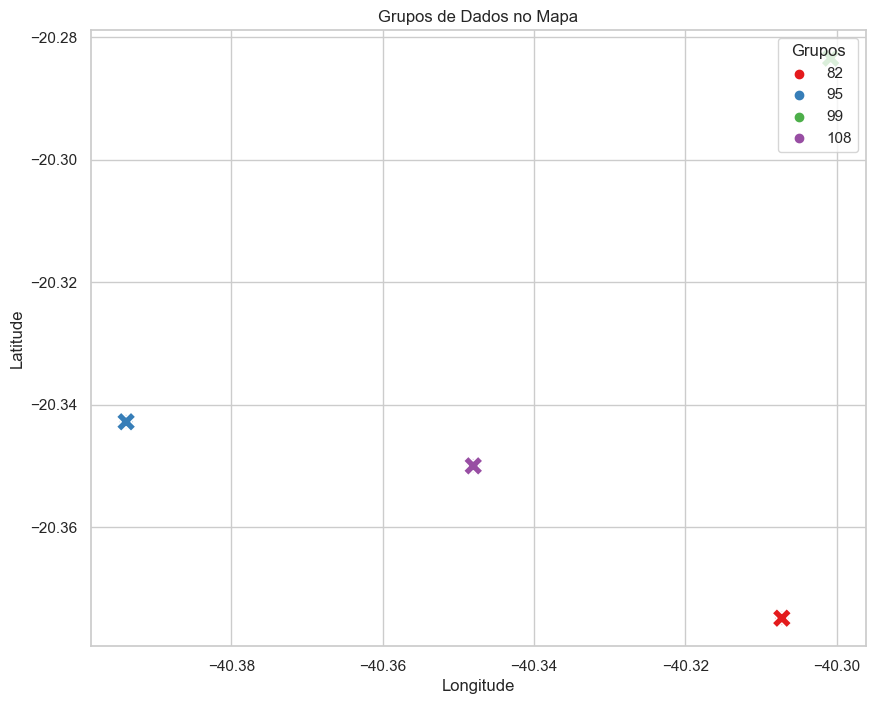

In [24]:
if len(list_to_stars_points) > 0:
    start_latitudes = list()
    start_longitudes = list()
    for points in list_to_stars_points:
        for point in points:
            start_latitudes.append(point[0])
            start_longitudes.append(point[1])
        
    new_df = pd.DataFrame({'lat': start_latitudes, 'long': start_longitudes})
    new_df_2 = pd.merge(new_df, clustered_df, on = ['lat', 'long'])

    x = plot_clusters_on_map(new_df_2, 'lat', 'long', 'cluster')
    
else:
    new_df_2 = teste[teste['index'].isin(starts)]
    x = plot_clusters_on_map(new_df_2, 'lat', 'long', 'index')

# Momento Gambiarra corrigir

In [25]:
# Visualização dos parametros ja inicializados 
print(list(starts))
print(list(ends))
print(n_routs_desirable)
print((demands))
print(total_demands)
print(depot)
print(list(vehicle_capacities))

[82, 95, 99, 108]
[0, 0, 0, 0]
4
[0, 5, 2, 2, 2, 3, 1, 3, 3, 3, 1, 1, 5, 4, 5, 4, 4, 1, 1, 1, 1, 6, 1, 2, 14, 19, 10, 12, 14, 5, 3, 5, 5, 8, 18, 17, 12, 11, 10, 12, 8, 14, 2, 5, 8, 3, 6, 1, 6, 1, 1, 2, 3, 1, 8, 4, 2, 4, 12, 13, 7, 18, 12, 6, 2, 9, 8, 4, 12, 6, 4, 13, 24, 2, 2, 2, 10, 5, 4, 14, 9, 2, 1, 1, 4, 1, 1, 2, 2, 1, 4, 1, 1, 2, 1, 1, 2, 1, 1, 2, 2, 2, 1, 1, 2, 1, 5, 1, 1, 1, 1, 2, 4, 1, 6, 1, 2, 2, 1, 2, 2, 3, 1, 1, 1, 2, 3, 2, 5, 4, 1, 1, 3, 5, 1, 2, 2, 1, 5, 3, 2, 1, 3]
637
0
[46, 46, 46, 46]


In [26]:
starts = [82, 95, 99, 108, 51, 70, 98, 23, 32, 48, 110, 114, 87, 12, 16, 14]
ends = [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]
n_routs_desirable = 16
depot = 0
demands = demands
vehicle_capacities = [46,46,46,46,46,46,46,46,46,46,46,46,46,46,46, 46]

In [27]:
print(len(starts))
print(len(ends))
print(demands)
print(len(vehicle_capacities))

16
16
[0, 5, 2, 2, 2, 3, 1, 3, 3, 3, 1, 1, 5, 4, 5, 4, 4, 1, 1, 1, 1, 6, 1, 2, 14, 19, 10, 12, 14, 5, 3, 5, 5, 8, 18, 17, 12, 11, 10, 12, 8, 14, 2, 5, 8, 3, 6, 1, 6, 1, 1, 2, 3, 1, 8, 4, 2, 4, 12, 13, 7, 18, 12, 6, 2, 9, 8, 4, 12, 6, 4, 13, 24, 2, 2, 2, 10, 5, 4, 14, 9, 2, 1, 1, 4, 1, 1, 2, 2, 1, 4, 1, 1, 2, 1, 1, 2, 1, 1, 2, 2, 2, 1, 1, 2, 1, 5, 1, 1, 1, 1, 2, 4, 1, 6, 1, 2, 2, 1, 2, 2, 3, 1, 1, 1, 2, 3, 2, 5, 4, 1, 1, 3, 5, 1, 2, 2, 1, 5, 3, 2, 1, 3]
16


# Projeção da rotas

In [28]:
"""Capacited Vehicles Routing Problem (CVRP)."""

from ortools.constraint_solver import routing_enums_pb2
from ortools.constraint_solver import pywrapcp


def create_data_model(distance_matrix, demands, vehicle_capacities, n_routs_desirable, depot, starts, ends):
    """Stores the data for the problem."""
    data = {}
    data["distance_matrix"] = distance_matrix
    data["demands"] = demands
    data["vehicle_capacities"] = vehicle_capacities
    data["num_vehicles"] = n_routs_desirable
    data["depot"] = depot
    data["starts"] = starts
    data["ends"] = ends
    return data


def print_solution(data, manager, routing, solution):
    """Prints solution on console."""
    print(f"Objective: {solution.ObjectiveValue()}")
    total_distance = 0
    total_load = 0
    max_route_distance = 0
    #####
    df_from_consult = list()
    #####
    for vehicle_id in range(data["num_vehicles"]):
        index = routing.Start(vehicle_id)
        plan_output = f"Route for vehicle {vehicle_id}:\n"
        route_distance = 0
        route_load = 0
        #########
        plans = list()
        points = list()
        ocupacao = list()
        ##########
        while not routing.IsEnd(index):
            node_index = manager.IndexToNode(index)
            route_load += data["demands"][node_index]
            plan_output += f" {node_index} Load({route_load}) -> "
            points.append(int(node_index))
            ocupacao.append(int(route_load))
            previous_index = index
            index = solution.Value(routing.NextVar(index))
            route_distance += routing.GetArcCostForVehicle(
                previous_index, index, vehicle_id
            )
        #####################
#         print(manager.IndexToNode(index))
#         print("!!!!!!!!!!!!!")
        #######################

        plan_output += f" {manager.IndexToNode(index)} Load({route_load})\n"
        ##########
        auxiliar_df = pd.DataFrame({'index': points, 'qtd': ocupacao})
        line_final = pd.DataFrame({'index': [manager.IndexToNode(index)], 'qtd': [0]})
        df_from_consult.append(pd.concat([auxiliar_df, line_final]))
        ##########
        plan_output += f"Distance of the route: {route_distance}m\n"
        plan_output += f"Load of the route: {route_load}\n"
        plans.append(plan_output)

#         print(plan_output)
        total_distance += route_distance
        total_load += route_load
#     print(f"Total distance of all routes: {total_distance}m")
#     print(f"Total load of all routes: {total_load}")

    return df_from_consult



def main():
    """Solve the CVRP problem."""
    # Instantiate the data problem.
    data = create_data_model(distance_matrix, demands, vehicle_capacities, n_routs_desirable, depot, starts, ends)

    # Create the routing index manager.
    manager = pywrapcp.RoutingIndexManager(
        len(data["distance_matrix"]), data["num_vehicles"], data["starts"], data["ends"]
    )

    # Create Routing Model.
    routing = pywrapcp.RoutingModel(manager)

    # Create and register a transit callback.
    def distance_callback(from_index, to_index):
        """Returns the distance between the two nodes."""
        # Convert from routing variable Index to distance matrix NodeIndex.
        from_node = manager.IndexToNode(from_index)
        to_node = manager.IndexToNode(to_index)
        return data["distance_matrix"][from_node][to_node]

    transit_callback_index = routing.RegisterTransitCallback(distance_callback)

    # Define cost of each arc.
    routing.SetArcCostEvaluatorOfAllVehicles(transit_callback_index)

    # Add Capacity constraint.
    def demand_callback(from_index):
        """Returns the demand of the node."""
        # Convert from routing variable Index to demands NodeIndex.
        from_node = manager.IndexToNode(from_index)
        return data["demands"][from_node]

    demand_callback_index = routing.RegisterUnaryTransitCallback(demand_callback)
    routing.AddDimensionWithVehicleCapacity(
        demand_callback_index,
        0,  # null capacity slack
        data["vehicle_capacities"],  # vehicle maximum capacities
        True,  # start cumul to zero
        "Capacity",
    )

    # Setting first solution heuristic.
    search_parameters = pywrapcp.DefaultRoutingSearchParameters()
    search_parameters.first_solution_strategy = (
        routing_enums_pb2.FirstSolutionStrategy.AUTOMATIC
#         routing_enums_pb2.FirstSolutionStrategy.PATH_CHEAPEST_ARC
    )
    search_parameters.local_search_metaheuristic = (
        routing_enums_pb2.LocalSearchMetaheuristic.AUTOMATIC
    )
    search_parameters.log_search = True
    search_parameters.time_limit.FromSeconds(15)
    
    # Solve the problem.
    solution = routing.SolveWithParameters(search_parameters)
    
    # Print solution on console.
    if solution:
        x = print_solution(data, manager, routing, solution)
        return x



x = main()

Objective: 745


# Funções de salvar e plotar as novas rotas

In [29]:
def capturate_points_in_routs(starts_and_end_points):
    latitudes = list()
    longitudes = list()
    for start_and_end_points in starts_and_end_points:
#         print(start_and_end_points)
        querystring = {"waypoints":f"{start_and_end_points}","mode":"drive"}
        response = requests.get(url, headers=headers, params=querystring, verify=False)
        
        for values in response.json()['features'][0]['geometry']['coordinates'][0]:
            latitudes.append(values[1])
            longitudes.append(values[0])
            
    return latitudes, longitudes

In [30]:
def capture_move(data_frame = pd.DataFrame()):
    moves = list()
    for index in data_frame.index[1:]:
        move = str()
        lat0 = str(data_frame.iloc[index]['lat1'])
        long0 = str(data_frame.iloc[index]['long1'])
        lat1 = str(data_frame.iloc[index]['lat'])
        long1 = str(data_frame.iloc[index]['long'])
        move = lat0+','+long0+'|'+lat1+','+long1
        moves.append(move)
    return moves

In [31]:
def capturate_points_in_routs(starts_and_end_points):
    latitudes = list()
    longitudes = list()
    for start_and_end_points in starts_and_end_points:
#         print(start_and_end_points)
        querystring = {"waypoints":f"{start_and_end_points}","mode":"drive"}
        response = requests.get(url, headers=headers, params=querystring, verify=False)
        
        for values in response.json()['features'][0]['geometry']['coordinates'][0]:
            latitudes.append(values[1])
            longitudes.append(values[0])
            
    return latitudes, longitudes

In [32]:
def plotar_mapa(latitudes, longitudes, latitudes_chaves, longitudes_chaves, dicas_ferramentas, name):
    # Cria um objeto de mapa Folium
    mapa = folium.Map(location=[sum(latitudes) / len(latitudes), sum(longitudes) / len(longitudes)], zoom_start=10)

    # Adiciona marcadores para cada par de latitude e longitude (invisíveis)
    for lat, lon in zip(latitudes, longitudes):
        folium.Marker(location=[lat, lon], opacity=0).add_to(mapa)

    # Adiciona uma linha conectando os pontos de latitude e longitude (duas vezes mais grossa)
    folium.PolyLine(zip(latitudes, longitudes), color='blue', weight=5, opacity=1).add_to(mapa)

    # Adiciona marcadores para os pontos-chave com dicas de ferramentas
    for lat, lon, dica in zip(latitudes_chaves, longitudes_chaves, dicas_ferramentas):
        folium.Marker(location=[lat, lon], popup=dica, icon=folium.Icon(color='red')).add_to(mapa)

    # Salva o mapa em um arquivo HTML
    mapa.save(f'{name}.html')

    return mapa


In [33]:
# def haversine_distance(lat1, lon1, lat2, lon2):
def distance_rout(latitudes, longitudes):
    auxilair_df = pd.DataFrame({'lat': latitudes, 'long': longitudes})
    auxilair_df['lat1'] = auxilair_df['lat'].shift(1)
    auxilair_df['long1'] = auxilair_df['long'].shift(1)
    auxilair_df['distance'] = haversine_distance(auxilair_df['lat'], auxilair_df['lat1'], auxilair_df['long'], auxilair_df['long1'])
    distance = auxilair_df['distance'].sum()
    return distance

# Salvar e plotar as rotas

In [34]:
dfs_from_locations = list()
for value in x:
    pos = 1
    for y in x:
        df_from_locations = y.merge(teste, on = ['index'], how='inner')
        df_from_locations['lat1'] = df_from_locations['lat'].shift(1)
        df_from_locations['long1'] = df_from_locations['long'].shift(1)
        df_from_locations.to_excel(f"rout_{pos}.xlsx", index=False)
        moves = capture_move(df_from_locations)
#         print(moves)
        latitudes, lagitudes = capturate_points_in_routs(moves)
        distance_rout(latitudes, lagitudes)
        plotar_mapa(latitudes, lagitudes, df_from_locations['lat'],  df_from_locations['long'], df_from_locations['nome_local'], f"rout_{pos}")
        pos += 1
        if pos > 16:
            break
    if pos > 16:
        break


In [5]:
print(help(ortools.constraint_solver.pywrapcp))

Help on module ortools.constraint_solver.pywrapcp in ortools.constraint_solver:

NAME
    ortools.constraint_solver.pywrapcp

DESCRIPTION
    # This file was automatically generated by SWIG (https://www.swig.org).
    # Version 4.1.1
    #
    # Do not make changes to this file unless you know what you are doing - modify
    # the SWIG interface file instead.

CLASSES
    builtins.object
        AssignmentElement
            IntVarElement
            IntervalVarElement
            SequenceVarElement
        BaseObject
            Decision
                PyDecision
            DecisionBuilder
                PyDecisionBuilder
            Demon
                PyDemon
                    PyConstraintDemon
            IntVarIterator
            LocalSearchFilter
                IntVarLocalSearchFilter
            LocalSearchFilterManager
            LocalSearchOperator
                IntVarLocalSearchOperator
                    BaseLns
                    ChangeValue
                  